In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')

In [7]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  96 non-null     float64
 1   SMB     96 non-null     float64
 2   HML     96 non-null     float64
 3   RMW     96 non-null     float64
 4   CMA     96 non-null     float64
 5   RF      96 non-null     float64
dtypes: float64(6)
memory usage: 5.2 KB


In [8]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.158542,0.060417,-0.049792,0.128750,0.047917,0.012604
std,3.580031,2.302008,2.202941,1.581701,1.411604,0.022583
min,-7.890000,-4.550000,-4.700000,-3.880000,-3.250000,0.000000
25%,-0.917500,-1.695000,-1.662500,-1.090000,-0.952500,0.000000
50%,1.235000,0.205000,-0.310000,0.190000,-0.005000,0.000000
75%,3.197500,1.590000,1.205000,1.197500,0.922500,0.010000
max,11.350000,7.070000,8.210000,3.480000,3.700000,0.090000


In [9]:
# using a panel of the 17 industry portfolios at a monthly frequency
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    96 non-null     float64
 1   Mines   96 non-null     float64
 2   Oil     96 non-null     float64
 3   Clths   96 non-null     float64
 4   Durbl   96 non-null     float64
 5   Chems   96 non-null     float64
 6   Cnsum   96 non-null     float64
 7   Cnstr   96 non-null     float64
 8   Steel   96 non-null     float64
 9   FabPr   96 non-null     float64
 10  Machn   96 non-null     float64
 11  Cars    96 non-null     float64
 12  Trans   96 non-null     float64
 13  Utils   96 non-null     float64
 14  Rtail   96 non-null     float64
 15  Finan   96 non-null     float64
 16  Other   96 non-null     float64
dtypes: float64(17)
memory usage: 13.5 KB


In [10]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.035417,0.210000,0.594896,1.383646,1.141771,1.327604,1.189063,1.734167,0.535521,1.350208,1.219271,1.282292,1.469792,0.894271,1.240417,1.247292,1.286250
std,2.805824,7.942856,5.504306,5.007997,5.207729,5.585949,3.141205,5.249994,7.424776,4.713899,4.801381,5.757512,4.167801,3.232446,3.519087,4.868399,3.674353
min,-5.160000,-24.510000,-11.760000,-9.770000,-13.170000,-16.770000,-7.180000,-14.140000,-20.570000,-12.180000,-9.110000,-11.770000,-8.660000,-7.110000,-9.200000,-11.290000,-8.040000
25%,-0.797500,-5.810000,-3.167500,-1.572500,-2.272500,-1.337500,-0.895000,-2.435000,-4.385000,-1.450000,-2.010000,-1.255000,-0.860000,-0.735000,-0.952500,-1.530000,-1.147500
50%,0.940000,-0.480000,0.990000,1.155000,1.225000,1.445000,1.465000,2.160000,0.655000,1.500000,1.495000,0.620000,1.520000,1.275000,0.885000,1.790000,1.570000
75%,3.210000,5.905000,4.195000,3.770000,4.627500,4.437500,3.295000,5.555000,4.270000,3.845000,4.582500,4.815000,4.342500,2.930000,3.367500,4.147500,3.425000
max,6.680000,22.030000,16.030000,17.320000,16.580000,18.360000,8.280000,15.580000,21.620000,17.870000,14.740000,21.040000,13.030000,7.840000,12.460000,13.500000,10.430000


In [11]:
# Get Equity Data
with pd.HDFStore('/Volumes/My Book/Data_Analysis/Nasdaq/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']
    equities = store['/us_equities/stocks'].drop_duplicates()

In [12]:
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [17]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1535 entries, A to ZUMZ
dtypes: float64(1535)
memory usage: 1.1 MB


In [14]:
# Align the Data
ff_factor_data = ff_factor_data.loc[returns.index]
ff_portfolio_data = ff_portfolio_data.loc[returns.index]

In [15]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206105,0.057474,-0.054842,0.143474,0.043579,0.012737
std,3.568400,2.314039,2.214069,1.583465,1.418450,0.022665
min,-7.890000,-4.550000,-4.700000,-3.880000,-3.250000,0.000000
25%,-0.565000,-1.700000,-1.665000,-0.925000,-0.965000,0.000000
50%,1.290000,0.160000,-0.310000,0.240000,-0.010000,0.000000
75%,3.265000,1.610000,1.220000,1.205000,0.935000,0.010000
max,11.350000,7.070000,8.210000,3.480000,3.700000,0.090000


In [18]:
# Compute excess returns
excess_returns = returns.sub(ff_factor_data.RF, axis=0)
excess_returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1535 entries, A to ZUMZ
dtypes: float64(1535)
memory usage: 1.1 MB


In [19]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

In [20]:
# Fama-Macbeth Regression
# it is useful to estimate the portfolio's exposure, that is, how much the risk factors drive portfolio returns
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    95 non-null     float64
 1   Mines   95 non-null     float64
 2   Oil     95 non-null     float64
 3   Clths   95 non-null     float64
 4   Durbl   95 non-null     float64
 5   Chems   95 non-null     float64
 6   Cnsum   95 non-null     float64
 7   Cnstr   95 non-null     float64
 8   Steel   95 non-null     float64
 9   FabPr   95 non-null     float64
 10  Machn   95 non-null     float64
 11  Cars    95 non-null     float64
 12  Trans   95 non-null     float64
 13  Utils   95 non-null     float64
 14  Rtail   95 non-null     float64
 15  Finan   95 non-null     float64
 16  Other   95 non-null     float64
dtypes: float64(17)
memory usage: 13.4 KB


In [21]:
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  95 non-null     float64
 1   SMB     95 non-null     float64
 2   HML     95 non-null     float64
 3   RMW     95 non-null     float64
 4   CMA     95 non-null     float64
dtypes: float64(5)
memory usage: 4.5 KB


In [22]:
# To address the inference problem caused by the correlation of the residuals, Fama and MacBeth proposed a 
# two-step methodology for a cross-sectional regression of returns on factors. The two-stage Fama—Macbeth 
# regression is designed to estimate the premium rewarded for the exposure to a particular risk factor by the 
# market. The two stages consist of:

# First stage: N time-series regression, one for each asset or portfolio, of its excess returns on the factors 
# to estimate the factor loadings.

# Second stage: T cross-sectional regression, one for each time period, to estimate the risk premium.


# Step 1: Factor Exposures
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))
    
# Fama-Macbeth Regression
# Fama-Macbeth Regression

In [23]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  17 non-null     float64
 1   SMB     17 non-null     float64
 2   HML     17 non-null     float64
 3   RMW     17 non-null     float64
 4   CMA     17 non-null     float64
dtypes: float64(5)
memory usage: 1.3+ KB


In [24]:
# Step 2: Risk Premia
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [25]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  95 non-null     float64
 1   SMB     95 non-null     float64
 2   HML     95 non-null     float64
 3   RMW     95 non-null     float64
 4   CMA     95 non-null     float64
dtypes: float64(5)
memory usage: 6.5 KB


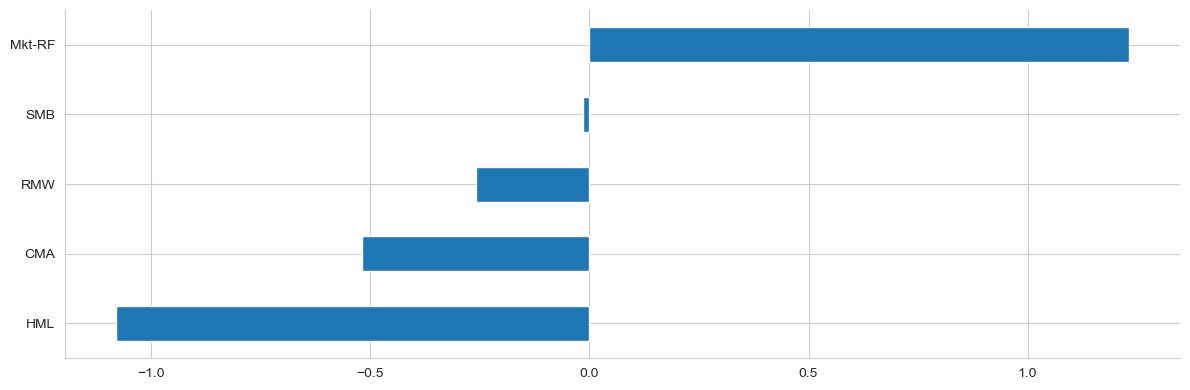

In [26]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [27]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.343411
SMB      -0.003533
HML      -0.266609
RMW      -0.086429
CMA      -0.147480
dtype: float64

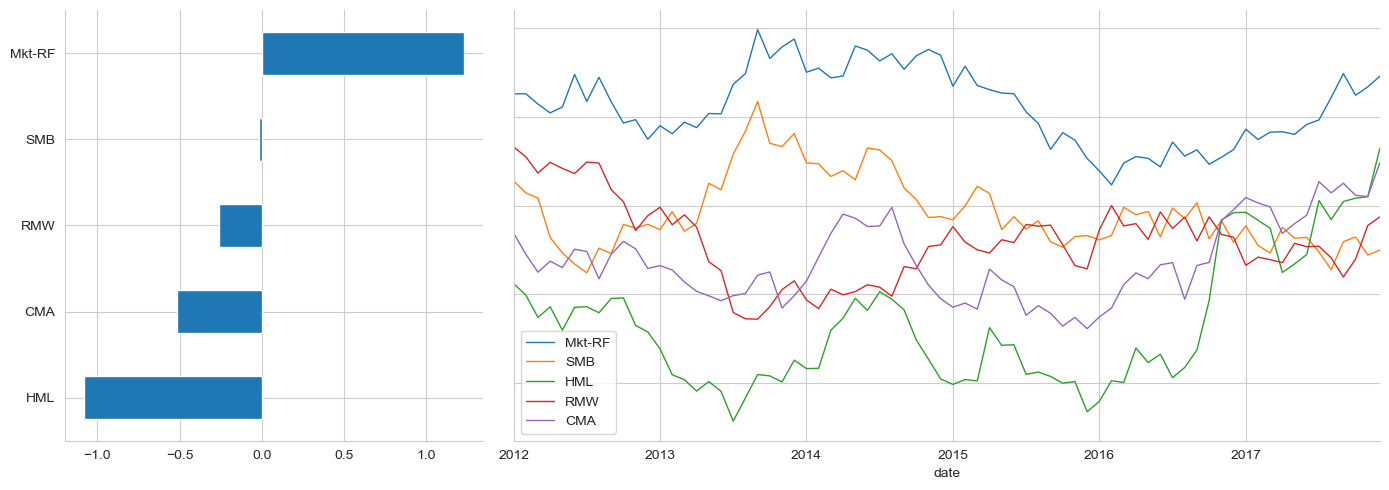

In [28]:
# Results
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

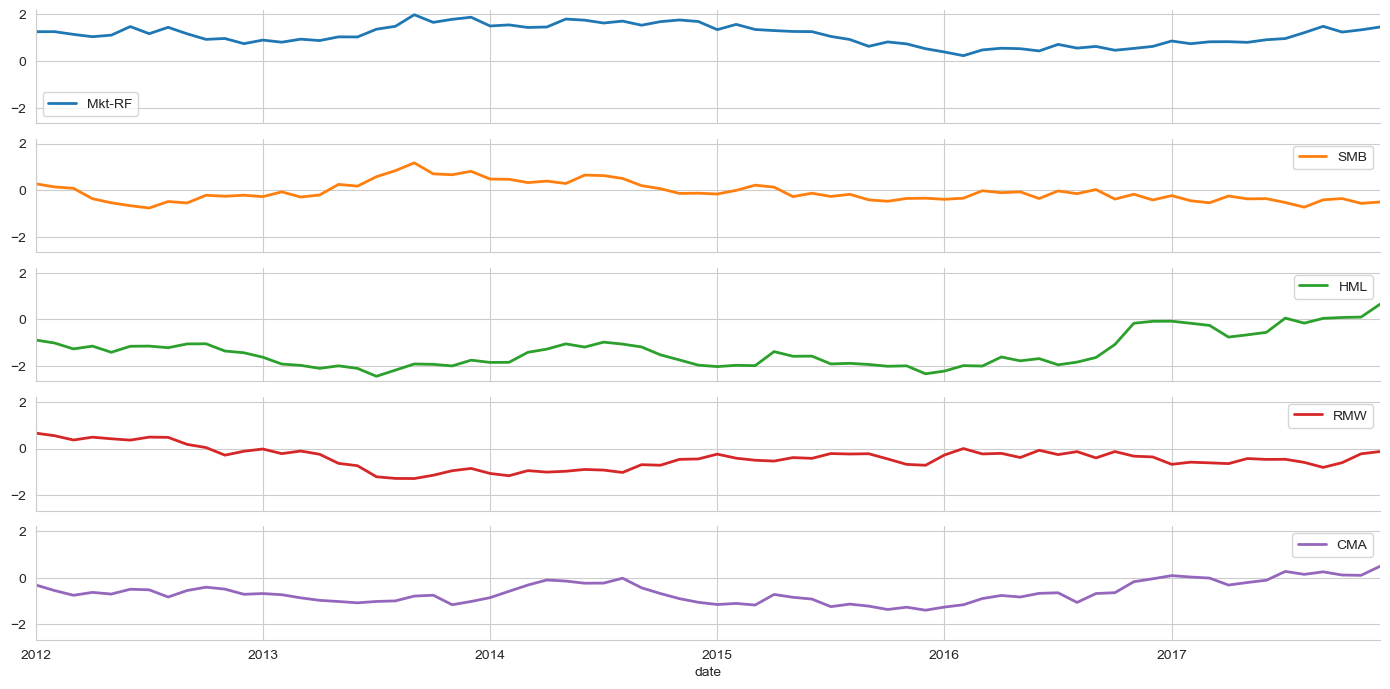

In [29]:
window = 24  # months
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()

In [30]:
# Fama-Macbeth with the LinearModels library - extends statsmodels with various models for panel data and 
# also implements the two-stage Fama—MacBeth procedure:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6896
No. Factors:                          5   J-statistic:                    15.927
No. Observations:                    95   P-value                         0.1946
Date:                  Tue, Mar 05 2024   Distribution:                 chi2(12)
Time:                          18:18:00                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2322     0.4068     3.0291     0.0025      0.4349      2.0294
SMB           -0.0138     0.8666    

In [31]:
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6896
No. Factors:                          5   J-statistic:                    15.927
No. Observations:                    95   P-value                         0.1946
Date:                  Tue, Mar 05 2024   Distribution:                 chi2(12)
Time:                          18:18:00                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2322     0.4068     3.0291     0.0025      0.4349      2.0294
SMB           -0.0138     0.8666    

In [32]:
lambdas.mean()

Mkt-RF    1.232159
SMB      -0.013818
HML      -1.080944
RMW      -0.258676
CMA      -0.518401
dtype: float64